In [4]:
import sys
import os
if not any(path.endswith('textbook') for path in sys.path):
    sys.path.append(os.path.abspath('../../..'))
from textbook_utils import *

In [5]:
# Prep sqlite database
# import sqlalchemy
# db = sqlalchemy.create_engine('sqlite:///babynames.db')

# csvs = [('babynames.csv', 'baby'), ('nyt_names.csv', 'nyt')]

# for csv, name in csvs:
#     df = pd.read_csv(csv)
#     df.to_sql(name, db, index=False, if_exists='replace')

(sec:sql_subsetting)=
# Subsetting


To work with relations, we'll introduce a domain-specific programming language
called **SQL** (Structured Query Language). We commonly pronounce "SQL" like
"sequel" instead of spelling out the acronym. SQL is a specialized language for
working with relations---as such, SQL has a different syntax than Python
for writing programs that operate on relational data.

In this chapter, we'll use SQL queries within Python programs. This illustrates
a common workflow---data scientists often process and subset data in SQL before
loading the data into Python for further analysis. SQL databases make it easier
to work with large amounts of data compared to `pandas` programs. However,
loading data into `pandas` makes it easier to visualize the data and build
statistical models.

:::{note}

Why do SQL systems tend to work better with larger datasets? In short, SQL systems have sophisticated algorithms for managing data stored on disk. For example, when working with a large dataset SQL systems will transparently load and manipulate small portions of data at a time; doing this in `pandas` can be quite difficult in comparison. We cover this topic in more detail in the {ref}`ch:files` chapter.

:::

## SQL Basics: `SELECT` and `FROM`

We'll use the `pd.read_sql` function which runs a SQL
query and stores the output in a `pandas` dataframe. Using this function requires some
setup. We start by importing the `pandas` and `sqlalchemy` Python packages.

In [6]:
import pandas as pd
import sqlalchemy

Our database is stored in a file called `babynames.db`. This file is a [SQLite](https://www.sqlite.org/index.html)
database, so we'll set up a `sqlalchemy` object that can process
this format.

In [7]:
db = sqlalchemy.create_engine('sqlite:///babynames.db')

:::{note}

In this book, we use SQLite, an extremely useful database system for working with data stored locally. Other
systems make different tradeoffs that are useful for different domains. For
instance, PostgreSQL and MySQL are more complex systems that are useful for large web applications where many end users are writing data at the same time. 
Although each SQL system has slight differences, they provide the same core SQL functionality. Readers may also be aware that Python provides SQLite support in its standard `sqlite3` library. We choose to use `sqlalchemy` because it's easier to reuse the code for other SQL systems beyond SQLite.

:::

Now, we can use `pd.read_sql` to run SQL queries on this database. This
database has two relations: `baby` and `nyt`. Here's a simple example that
reads in the entire `baby` relation.

In [8]:
# SQL query saved in a Python string
query = ''' 
SELECT *
FROM baby;
'''

pd.read_sql(query, db)

,Name,Sex,Count,Year
0,Liam,M,19659,2020
1,Noah,M,18252,2020
2,Oliver,M,14147,2020
...,...,...,...,...
2020719,Verona,F,5,1880
2020720,Vertie,F,5,1880
2020721,Wilma,F,5,1880


The text inside the `query` variable contains SQL code. `SELECT` and `FROM` are
SQL keywords. We read the query above like:

```sql
SELECT *    -- Get all the columns...
FROM baby;  -- ...from the baby relation
```

The `baby` relation contains the same data as the `baby` dataframe in the {ref}`ch:pandas` chapter: the names of all babies registered by the US Social Security department.

## What's a Relation?

Let's examine the `baby` relation in more detail. A relation has rows and
columns. Every column has a label, as illustrated in
{numref}`fig:relation-labels`. Unlike dataframes, however, individual rows in a
relation don't have labels. Also, unlike dataframes, rows of a relation aren't
ordered.

```{figure} figures/relation-labels.svg
---
name: fig:relation-labels
alt: relation-labels
---
The `baby` relation has labels for columns (boxed).
```

Relations have a long history. More formal treatments of relations use the term
"tuple" to refer to the rows of a relation, and "attribute" to refer to the
columns. There is also a rigorous way to define data operations using
relational algebra, which is derived from mathematical set algebra.

## Slicing

*Slicing* is an operation that creates a new relation by taking a subset of
rows or columns out of another relation. Think about slicing a tomato---slices
can go both vertially and horizontally. To slice columns of a relation, we give
the `SELECT` statement the columns we want. 

In [9]:
query = ''' 
SELECT Name
FROM baby;
''' 

pd.read_sql(query, db)

,Name
0,Liam
1,Noah
2,Oliver
...,...
2020719,Verona
2020720,Vertie
2020721,Wilma


In [10]:
query = ''' 
SELECT Name, Count
FROM baby;
''' 

pd.read_sql(query, db)

,Name,Count
0,Liam,19659
1,Noah,18252
2,Oliver,14147
...,...,...
2020719,Verona,5
2020720,Vertie,5
2020721,Wilma,5


To slice out a specific number of rows, use the `LIMIT` keyword:

In [11]:
query = ''' 
SELECT Name
FROM baby
LIMIT 10;
''' 

pd.read_sql(query, db)

,Name
0,Liam
1,Noah
2,Oliver
...,...
7,Lucas
8,Henry
9,Alexander


In sum, we use the `SELECT` and `LIMIT` keywords to slice columns and rows
of a relation.

## Filtering Rows

Now, we turn to *filtering* rows---taking subsets of rows using one or more criteria. In `pandas`, we slice dataframes using Boolean series objects. In SQL, we instead use the `WHERE` keyword with a predicate. The query below filters the `baby` relation to have only the baby names in 2020:

In [12]:
query = ''' 
SELECT *
FROM baby
WHERE Year = 2020;
'''

pd.read_sql(query, db)

,Name,Sex,Count,Year
0,Liam,M,19659,2020
1,Noah,M,18252,2020
2,Oliver,M,14147,2020
...,...,...,...,...
31267,Zylynn,F,5,2020
31268,Zynique,F,5,2020
31269,Zynlee,F,5,2020


:::{warning}

Note that when comparing for equality, SQL uses a single equals sign:

```sql
SELECT *
FROM baby
WHERE Year = 2020;
--         ↑
--         Single equals sign
```

In Python, however, single equals signs are used for variable assignment. The
statement `Year = 2020` will assign the value `2020` to the variable `Year`. To
compare for equality, Python code uses double equals signs:

```python
# Assignment
my_year = 2021

# Comparison, which evaluates to False
my_year == 2020
```

:::

To add more predicates to the filter, use the `AND` and `OR` keywords. For
instance, to find the names that have more than 10000 babies in either 2020 or
2019, we write:

In [13]:
query = ''' 
SELECT *
FROM baby
WHERE Count > 10000
  AND (Year = 2020
       OR Year = 2019);
-- Notice that we use parentheses to enforce evaluation order
'''

pd.read_sql(query, db)

,Name,Sex,Count,Year
0,Liam,M,19659,2020
1,Noah,M,18252,2020
2,Oliver,M,14147,2020
...,...,...,...,...
41,Mia,F,12452,2019
42,Harper,F,10464,2019
43,Evelyn,F,10412,2019


Finally, to find the ten most common names in 2020, we can sort the dataframe
by `Count` in descending order using the `ORDER BY` keyword with the `DESC`
option (short for DESCending).

In [14]:
query = ''' 
SELECT *
FROM baby
WHERE Year = 2020
ORDER BY Count DESC
LIMIT 10;
'''

pd.read_sql(query, db)

,Name,Sex,Count,Year
0,Liam,M,19659,2020
1,Noah,M,18252,2020
2,Emma,F,15581,2020
...,...,...,...,...
7,Sophia,F,12976,2020
8,Amelia,F,12704,2020
9,William,M,12541,2020


We see that Liam, Noah, and Emma were the most popular baby names in 2020.

## Example: How recently has Luna become a popular name?

As we mention in the chapter introducing `pandas`, 
a New York Times article mentions that the name "Luna" was almost nonexistent
before 2000 but has since grown to become a very popular name for girls.
When exactly did Luna become popular?
We can check this in SQL using slicing and filtering.

In [15]:
query = ''' 
SELECT *
FROM baby
WHERE Name = "Luna"
  AND Sex = "F";
'''

luna = pd.read_sql(query, db)
luna

,Name,Sex,Count,Year
0,Luna,F,7770,2020
1,Luna,F,7772,2019
2,Luna,F,6929,2018
...,...,...,...,...
125,Luna,F,17,1883
126,Luna,F,18,1881
127,Luna,F,15,1880


`pd.read_sql` returns a `pandas.DataFrame` object, which we can use to make
a plot.  This illustrates a common workflow: process the data using SQL, load
it into a `pandas` dataframe, then visualize the results.

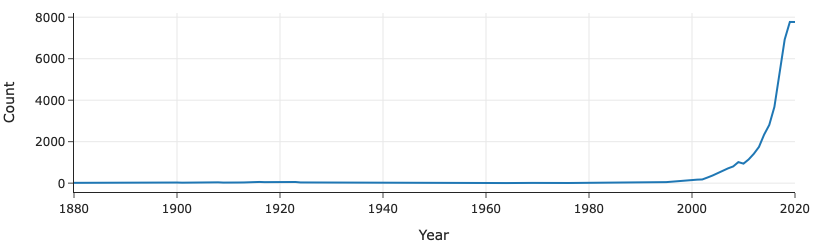

In [16]:
px.line(luna, x='Year', y='Count', width=350, height=250)

In this section, we introduce the common ways that data scientists subset relations---slicing with column labels and filtering using a boolean condition.
In the next section, we explain how to aggregate rows together.